# Lab 10

This week, we are focusing on gradient descent. Like last week, we wil be using the fake employee dataset with the goal of finding the best parameters for linear regression. The goals for this week are:

0. Reviewing grid search and the drawbacks of it
1. Motivate the process for gradient descent
2. Detail the steps of gradient descent
3. Define the learning rate for gradient descent and the impact of it on the speed of the algorithm





### Imports for Today

Let us import the packages that we need for today and the dataset from last time. You may want to simply make a copy of the data in the Lab 10 directory. 

In [1]:
## Import block
%matplotlib notebook 

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd

from sklearn import linear_model

In [7]:
## Functions for later use

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color="lightblue")
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    
def place_parameter(p_vec, col, ax=None):
    plt.scatter(p_vec[0],p_vec[1], c=col, marker = "*", s = 100)
    
def draw_parameter_path(p0,p1, col, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color=col)
    ax.annotate('', p1, p0, arrowprops=arrowprops)   
    
def compute_mse(truth_vec, predict_vec):
    return np.mean((truth_vec - predict_vec)**2)
    
def compute_m_partial(in_vals, truth_vec, predict_vec):
    return -2*np.mean(in_vals*(truth_vec - predict_vec))

def compute_b_partial(truth_vec, predict_vec):
    return -2*np.mean(truth_vec - predict_vec)

In [3]:
## Import Data

employ_data = pd.read_csv("../Lab09-Parameters/lab9data.csv", sep = ",")

## numpy vectors of our inputs
neuro = employ_data[["neuroticism"]].to_numpy()
perform = employ_data[["performance"]].to_numpy()

In [ ]:
# For function testing 




### Where are we? 

The example that we've been carrying around is about building a line that does the best job of prediction. 

In our specific case, we are working to predict someone's performance score based on a score from a personality test. We are seeking the right $m$ and $b$ for the equation: `performance = m*neuro + b`. 

So far, we've found the values for these parameters in two ways:
1. Using linear regression which uses some linear algebra to state the best values
2. Using grid search

The first option has the drawback that (in this class) we have not delved into why and how linear regression works. The second also has drawbacks, namely that it can be computationally expensive, which we will discuss in more detail below. 

### Reviewing Grid Search

Last time, we introduced grid search, a process of testing all combinations of parameter values by first laying out a _grid_ of the combinations with each parameter on its own axis. For example: 

<table>
<thead>
<tr>
    <th></th>
<th>m = 0</th>
    <th>m = 0.5</th>
    <th>m = 1.5</th>
    <th>m = 2</th>
    <th>...</th>
</tr>
</thead>
<tbody>
<tr>
<th>b = 0</th>
    <td>(0,0) </td>
    <td>(0,0.5)</td>
    <td>(0,1.5) </td>
    <td>(0,2)</td>
    <td>(0,...) </td>
</tr>
<tr>
<th>b = 1/3</th>
    <td>(1/3,0) </td>
    <td>(1/3,0.5)</td>
    <td>(1/3,1.5) </td>
    <td>(1/3,2)</td>
    <td>(1/3,...) </td>
</tr>
<tr>
<th>b = 2/3</th>
    <td>(2/3,0) </td>
    <td>(2/3,0.5)</td>
    <td>(2/3,1.5) </td>
    <td>(2/3,2)</td>
    <td>(2/3,...) </td>
</tr>
<tr>
<th>b = 1</th>
    <td>...</td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
</tr>
<tr>
<th>b = 4/3</th>
    <td>...</td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
</tr>
</tbody>
</table>


In a grid search, we then replace each entry with some evaluation metric relating to how those parameters do when plugged into a desired algorithmic formulation (say a line $y = m*x+b$) at predicting our data. Last class, we will use the _mean squared error_ for this evaluation:

$MSE(truth, guess) = avg(truth - guess)^2$

Say we have $n_1$ number of possible values for the first parameter and $n_2$ number of possible values for the second parameter, how many times do we compute the MSE? 


(Add your thoughts here and then fill in the below blank)

**Fill in this blank:**
We will compute the MSE $n_1\cdot n_2$ times.

#### Grid Search drawback

This is a lot of computations! After all these computations, we then have to compute a minimum of all of those results! (which is even more computation)

**Gradient descent** allows us to speed this process up and allows us to find the minimum more directly. Let's take moment to see how this could work by reminding ourselves of the surface created by the evaluation matrix last time.

(Below is my implementation, just to have as reference. You are welcome to replace the below block with your own implementation. There is more than one way to code a grid search!)

In [4]:
# Set the possible values for our parameters
m_vec = np.arange(-3, 10, 0.1)
b_vec = np.arange(-2, 60, 0.2)

# Create a place to store the values 
# HINT - Look at the above matrix! 
eval_mat = np.zeros([len(m_vec),len(b_vec)])

# Try (or loop over) all possible combinations
# HINT think nested
for m_inds in range(len(m_vec)):
    m = m_vec[m_inds]
    for b_inds in range(len(b_vec)):
        b = b_vec[b_inds]
        preds = m*neuro + b
        
        goodness = compute_mse(perform,preds)
        eval_mat[m_inds,b_inds] = goodness

<IPython.core.display.Javascript object>


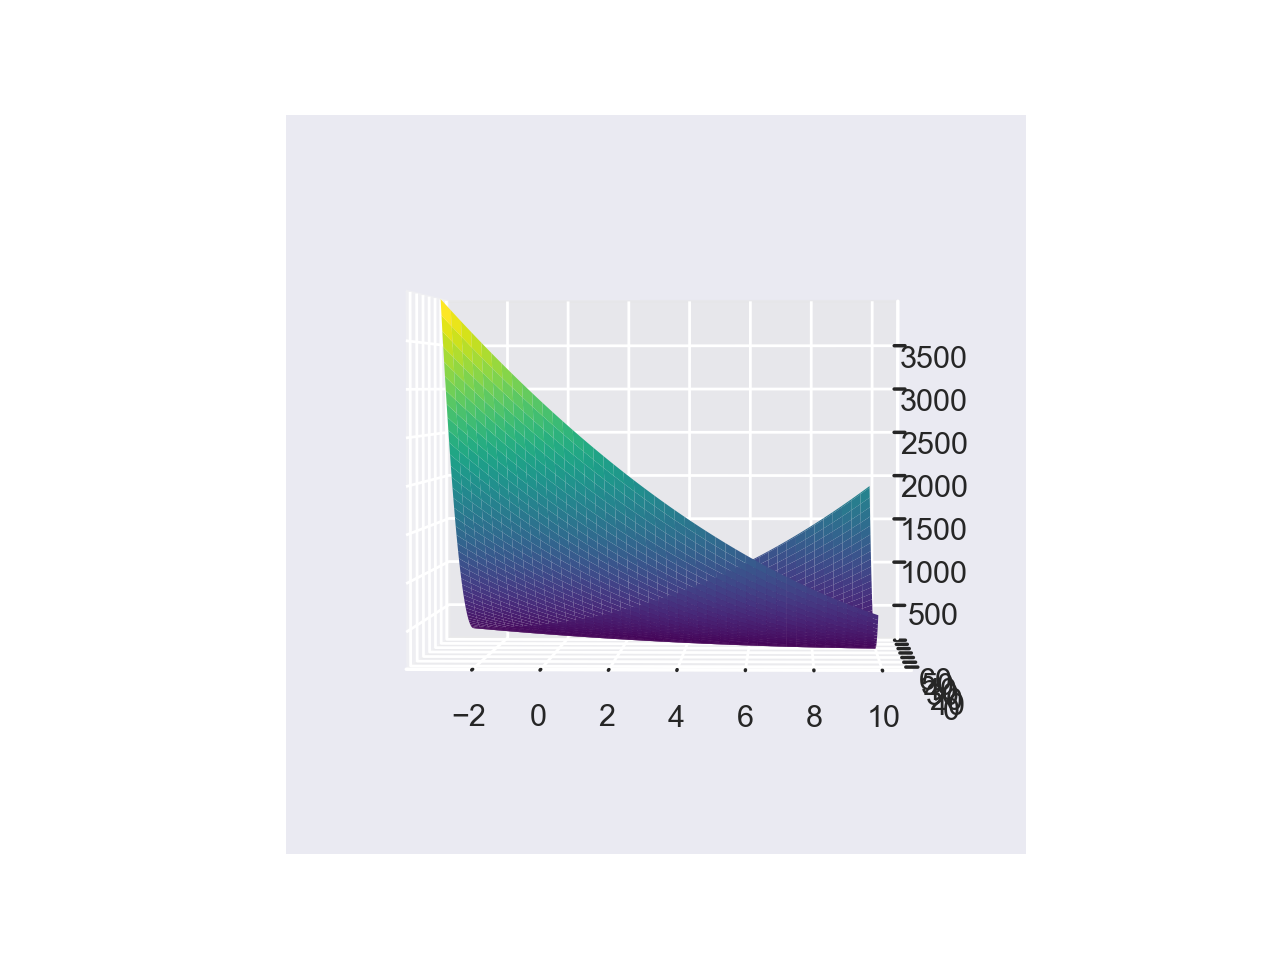

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')
bs,ms = np.meshgrid(b_vec,m_vec)

# Create the SCATTER() plot with colors
ax.plot_surface(ms,bs, eval_mat, cmap='viridis',edgecolor='none');


#### Metaphor for gradient descent

Gradient descent is nearly how it sounds: we will *descend* towards the best fitting parameter values (in this case $m$ and $b$) by moving in the direction of greatest negative change, as specified by the *gradient.*

To visualize what we will be doing, pick a high place on the surface and with the goal of finding the lowest point on the surface. How would you travel/sled/slide down the surface to arrive at this minimum? 

(Trace your path with your finger, not code)

Does your path always move such that you are parallel to the $m$-axis and/or parallel to the $b$-axis? 

(Your thoughts)

**_Wait here for a group discussion_**

#### Charting a path

As you can imagine, charting this path may curve as you move down the surface. Instead of trying to define one direct complete from the beginning, we aim to _descend,_ little by little as dictated by the _gradient._ So what is the gradient exactly?

To answer this, let's consider that we begin our search at $m=0$ and $b=0$. How should we change $m$ and $b$ to move towards the minimum fastest? 

## Gradient

The gradient is a version of a multi-variable derivative, whose direction tells us how to move in the steepest direction. If we move in the (positive) gradient direction this yields the greatest increase; while the opposite (or negative) gradient direction is the direction of greatest descent. Effectively, the gradient is the answer to the question _"How should we change the parameters to move towards the minimum fastest?"_ 

The gradient a vector comprised of the partial derivatives with respect to each parameter. When dealing with derivatives, we must first clarify what we are taking a derivative of. In our running example, what are we trying to descend? Justify your choice. 


**_Wait here for a group discussion_**

### Partial derivatives on evaluation metric 

We are attempting to descend the surface created by the evaluation metric. We need the gradient to tell us which direction to move on the $(m,b)$ parameter space to descend on the evaluation metric surface the quickest. This means that we need to compute:

1. The partial derivative of the MSE with respect to $m$, and 
2. The the partial derivative of the MSE with respect to $b$. 

#### With respect to $m$

Let's begin with the first one. Recall that we defined MSE as:

\begin{equation}
MSE(truth, guess) = avg(truth - guess)^2
\end{equation}

For ease of notation, let's refer to "truth" or the true performance score as $p_i$ for each $i$ data point. Similarly, let $n_i$ be the neuroticism score. This notation means that the "guess" for each $i$ data point is given by $(m*n_i + b)$ for current values of $m$ and $b$. If $D$ is the number of datapoints, we can re-write this MSE as:

\begin{equation}
MSE = \dfrac{1}{D}\Sigma_{i}(p_i - (m*n_i + b))^2
\end{equation}

Now, to take the partial derivative with respect to $m$, we treat every notation -- except $m$ -- in our equation as a **fixed** number (like the number 4) and treat $m$ as something that can vary (or as something that is unknown). 

Recalling that the derivative of $(f(x))^2$ is $2*f(x)*f'(x)$ (or 2 times the original function times the derivative of the original function) by the chain rule, then the partial derivative of MSE with respect to $m$ (denoted as $d_m(MSE)$) is: 

\begin{equation}
d_m(MSE) = d_m(\dfrac{1}{D}\Sigma_{i}(p_i - (m*n_i + b))^2)\\
~\hspace{3cm} = \dfrac{1}{D}\Sigma_{i} 2*(p_i - (m*n_i + b))*(-n_i) \\
~\hspace{2cm} = \dfrac{-2}{D}\Sigma_{i} (n_i)(p_i - (m*n_i + b))
\end{equation}

Interpreting this into the original formulation, we have that the partial derivative of MSE with respect to $m$ is: 

\begin{equation}
d_m(MSE) = -2*avg((input\_values)*(truth - (guess)))
\end{equation}

Now that we have this partial derivative, we plug in the **current** values for each of these components. The resulting value tells us how far to move in the $m$ direction. 

In the function block, there is a function `compute_m_partial` that currently just `pass`es. Please complete this formula. 

#### With respect to $b$

The second one is much like the first. We begin with the re-written MSE, treating every notation -- except $b$ -- in our equation as a **fixed** number (like the number 4) and treat $b$ as something that can vary (or as something that is unknown): 

\begin{equation}
d_b(MSE) = d_b(\dfrac{1}{D}\Sigma_{i}(p_i - (m*n_i + b))^2)\\
~\hspace{3cm} = \dfrac{1}{D}\Sigma_{i} 2*(p_i - (m*n_i + b))*(-1) \\
~\hspace{2cm} = \dfrac{-2}{D}\Sigma_{i} (p_i - (m*n_i + b))
\end{equation}

Interpreting this into the original formulation, we have that the partial derivative of MSE with respect to $m$ is: 

\begin{equation}
d_b(MSE) = -2*avg((truth - (guess)))
\end{equation}

Now that we have this partial derivative, we plug in the **current** values for each of these components. The resulting value tells us how far to move in the $b$ direction. 

In the fuction block, there is a function `compute_b_partial` that currently just `pass`es. Please complete this formula. 

#### Using the partial derivatives

The partial derivatives tell us the steepest direction to move in from our current point. Since we want to move towards the minimum, we choose to move in the direction of the negative gradient. 

We also want to decide how much we want to move each time. Let's call this value $L$ (for learning rate). We'll discuss the learning rate next time. 

That is, we update our values for $m$ and $b$ as follows:

\begin{equation}
m_{new} = m - L*d_m(MSE) \\
b_{new} = b - L*d_b(MSE)
\end{equation}

#### Each Journey begins with a single step

Starting with $m=0$ and $b=0$, compute the gradient and update your values for $m$ and $b$ setting $L = 0.01$. Chart your this first step on the below plot: 

In [8]:
# Set starting point for m and b (called m0 and b0)
m0 = 0
b0 = 0

# Computing the gradient
preds = m0*neuro + b0
d_m = compute_m_partial(neuro, perform, preds)
d_b = compute_b_partial(perform, preds)

# Set L
L = 0.01

# Updating the parameter values 
m1 = m0 - L*d_m
b1 = b0 - L*d_b

print(d_b)
print(m1,b1)


-98.85264386954589
3.1368874428319486 0.9885264386954589


<IPython.core.display.Javascript object>


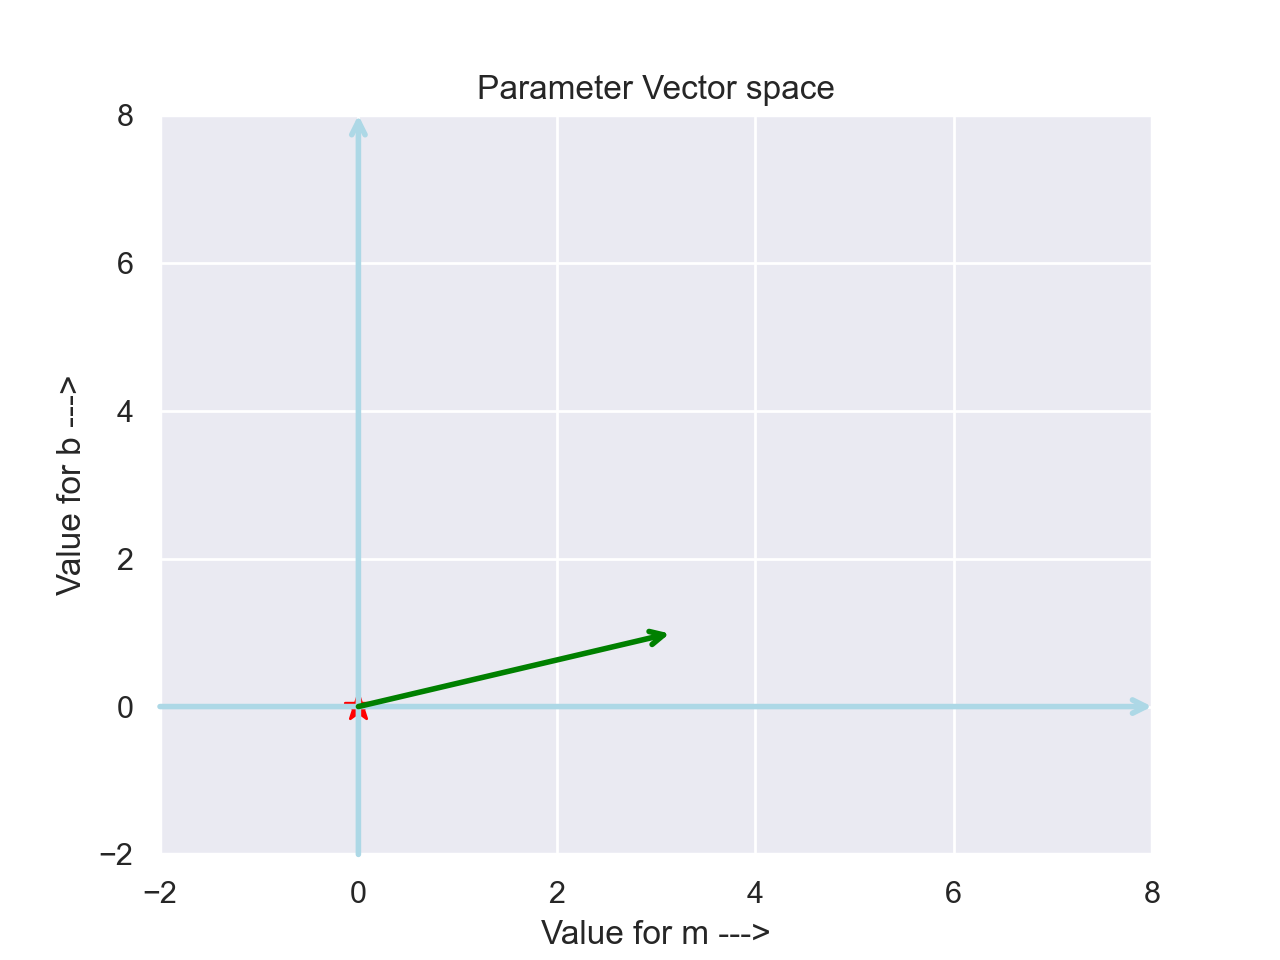

Text(0.5, 1.0, 'Parameter Vector space')

In [9]:
fig = plt.figure()

# Set axis limits
xmin = -2
xmax = 8
ymin = -2
ymax = 8

plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

# Build axes
draw_vector([xmin,0], [xmax,0])
draw_vector([0,ymin], [0,ymax])

# Starting place 
place_parameter([0,0],"red")

# First step
draw_parameter_path([m0,b0],[m1,b1],"green")

# Create grid and labels
plt.grid(True)
plt.xlabel('Value for m --->')
plt.ylabel('Value for b --->')
plt.title('Parameter Vector space')

Compute the next step and plot it on your image. What do you notice? 

In [10]:
# Code block for you


# Computing the gradient
preds = m1*neuro + b1
d_m = compute_m_partial(neuro, perform, preds)
d_b = compute_b_partial(perform, preds)

# Set L
L = 0.01

# Updating the parameter values 
m2 = m1 - L*d_m
b2 = b1 - L*d_b

print(d_b)
print(m2,b2)


-77.59237839126558
5.555020234254837 1.7644502226081147


<IPython.core.display.Javascript object>


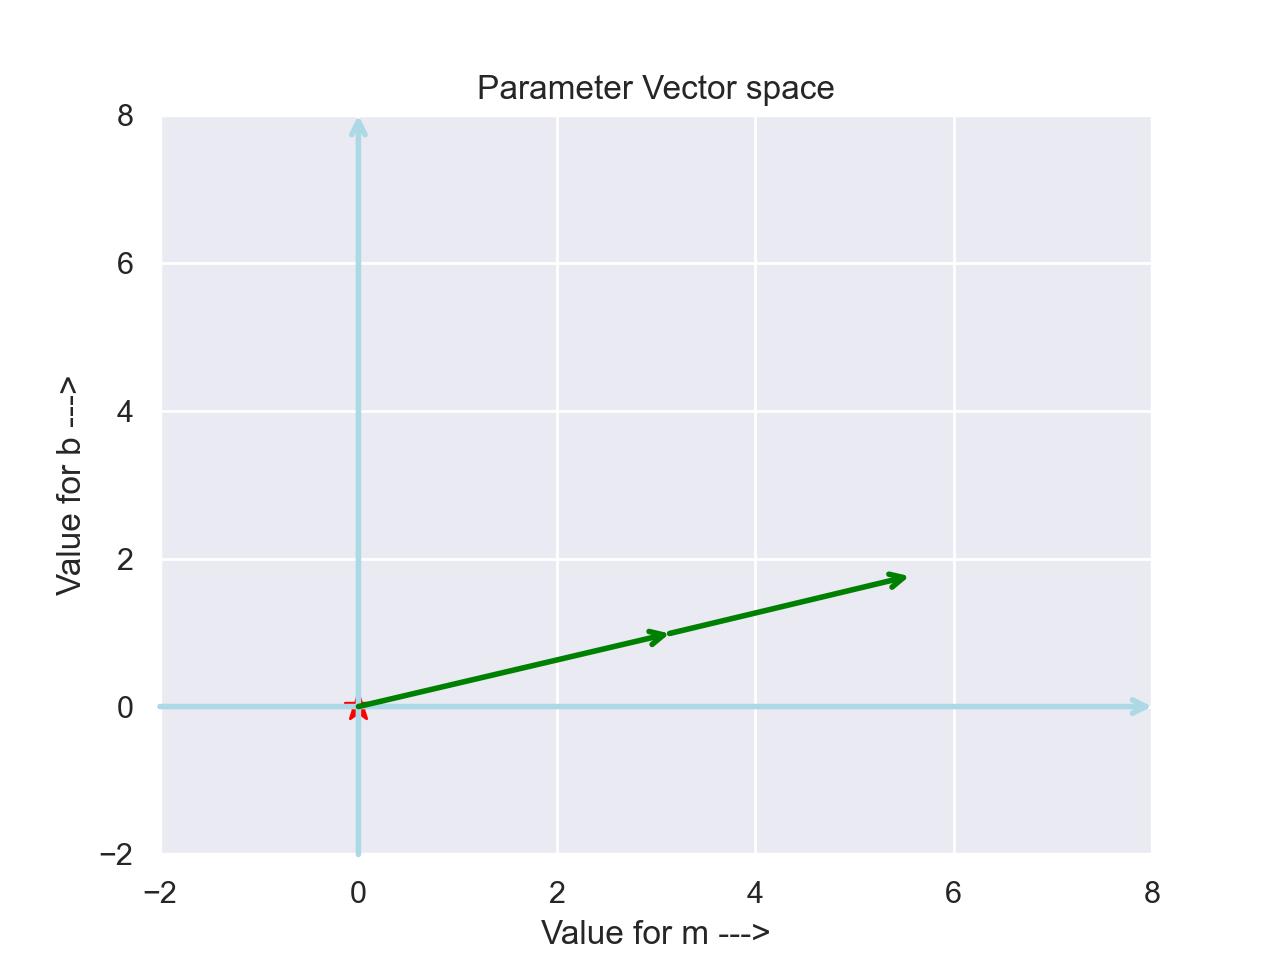

Text(0.5, 1.0, 'Parameter Vector space')

In [11]:
# plotting block for you 
fig = plt.figure()

# Set axis limits
xmin = -2
xmax = 8
ymin = -2
ymax = 8

plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

# Build axes
draw_vector([xmin,0], [xmax,0])
draw_vector([0,ymin], [0,ymax])

# Starting place 
place_parameter([0,0],"red")

# First step
draw_parameter_path([m0,b0],[m1,b1],"green")
draw_parameter_path([m1,b1],[m2,b2],"green")

# Create grid and labels
plt.grid(True)
plt.xlabel('Value for m --->')
plt.ylabel('Value for b --->')
plt.title('Parameter Vector space')

### Adding more steps

At its core, **gradient descent** is a series of steps dictated by the _gradient_ _descending_ an evaluation surface. 

In the below code block, create an iterative process that creates lists of $m$ values, $b$ values, and the MSE associated to it. We should be able to state the number of steps `n_steps` and decend that number of times. 

In [15]:
# Initialize the number of steps you wish to take
# Set your learning rate
n_steps = 500
L = 0.01

# Initialize starting parameters
m = 0
b = 0

# Create empty lists to store values for m, b, and the associated MSE
outm = []
outb = []
outmse = []

# Create an iterative process (ie. a loop) that will take N_STEPS
#           Note: you likely need to take at least 500 steps
for stp in range(n_steps):
    # For the current values of m and b: 
    
    # 1. Compute the MSE
    preds = m*neuro + b
    errormse = compute_mse(perform,preds)
    
    # 2. Store m, b, and the associated MSE in the output lists:
    outm.append(m)
    outb.append(b)
    outmse.append(errormse)
    
    # Update m and b by:
    
    # 1. Computing the gradient
    d_m = compute_m_partial(neuro,perform,preds)
    d_b = compute_b_partial(perform, preds)
    
    # Update the values for m and b
    m = m - (L*d_m)
    b = b - (L*d_b)
    
    

Now, plot your path with the parameters selected by the `sklearn` implementation of linear regression. 

<IPython.core.display.Javascript object>


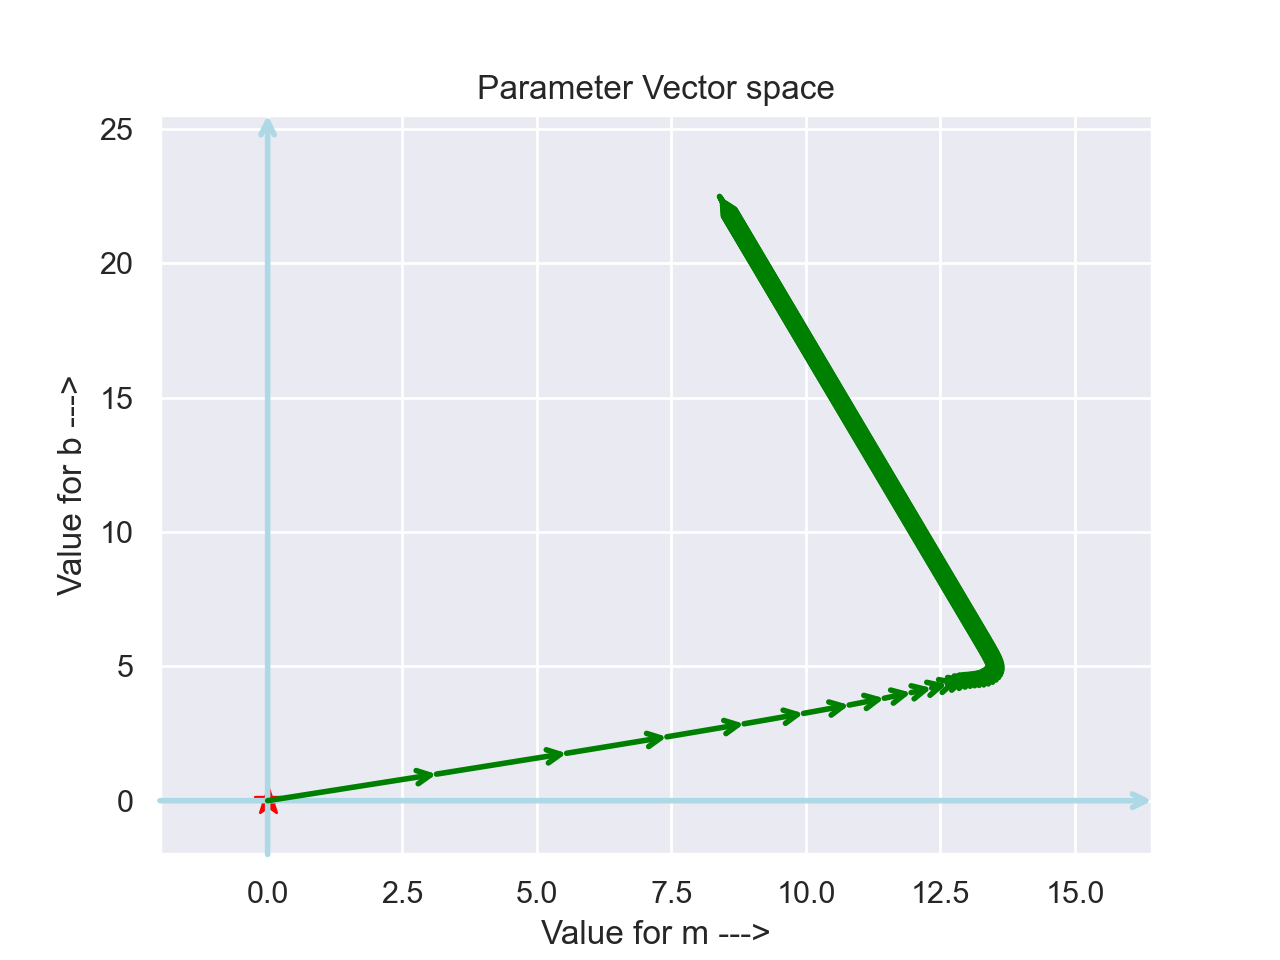

Text(0.5, 1.0, 'Parameter Vector space')

In [16]:
# Plot your results here
# plotting block for you 

fig = plt.figure()

# Set axis limits
xmin = -2
xmax = max(outm) + 3
ymin = -2
ymax = max(outb) + 3

plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

# Build axes
draw_vector([xmin,0], [xmax,0])
draw_vector([0,ymin], [0,ymax])

# Starting place 
place_parameter([0,0],"red")

# plot vectors
for stp in range(n_steps - 1):
    draw_parameter_path([outm[stp], outb[stp]],[outm[stp+1], outb[stp+1]],"green")

# Create grid and labels
plt.grid(True)
plt.xlabel('Value for m --->')
plt.ylabel('Value for b --->')
plt.title('Parameter Vector space')

## Next time

Putting this all together into gradient descent with a proper learning rate. 

### Final Thoughts

To finish up this lab, compute the first 50 steps using the gradient. Create a plot with both the first 50 steps AND the best values of $m$ and $b$ according to the linear regression from `sklearn`. 
Share your plot in a post on **#lab10_submission** channel on slack and share something that you find odd you about your plot. 

If your have questions from this lab, post them to #lab_questions with the same preamble (i.e. starting with **Lab10**). If you have the same question, please use one of the emoji's to upvote the question. If you would like to answer someone's question, please use the thread function. This will tie your answer to their question. 

#### Resources consulted 

0. _Doing Data Science: Straight talk from the frontline_ by C. O'Neil & R. Schutt (2014)
1. [Linear Regression using Gradient Descent](https://towardsdatascience.com/linear-regression-using-gradient-descent-97a6c8700931)
2. [Gradient in Wolfram](http://mathworld.wolfram.com/Gradient.html)